<a href="https://colab.research.google.com/github/suhkisoo/course-v3/blob/master/Colorization_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 5.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [5]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'decolorize'

In [6]:
from PIL import Image, ImageDraw, ImageFont

class decolorizer(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn).convert("L")
        img.save(dest)

In [7]:
il = ImageList.from_folder(path_hr)
parallel(decolorizer(path_lr, path_hr), il.items)

In [8]:
bs,size=32, 128
arch = models.resnet34

## Pre-train generator

In [9]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [10]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [11]:
data_gen = get_data(bs,size)

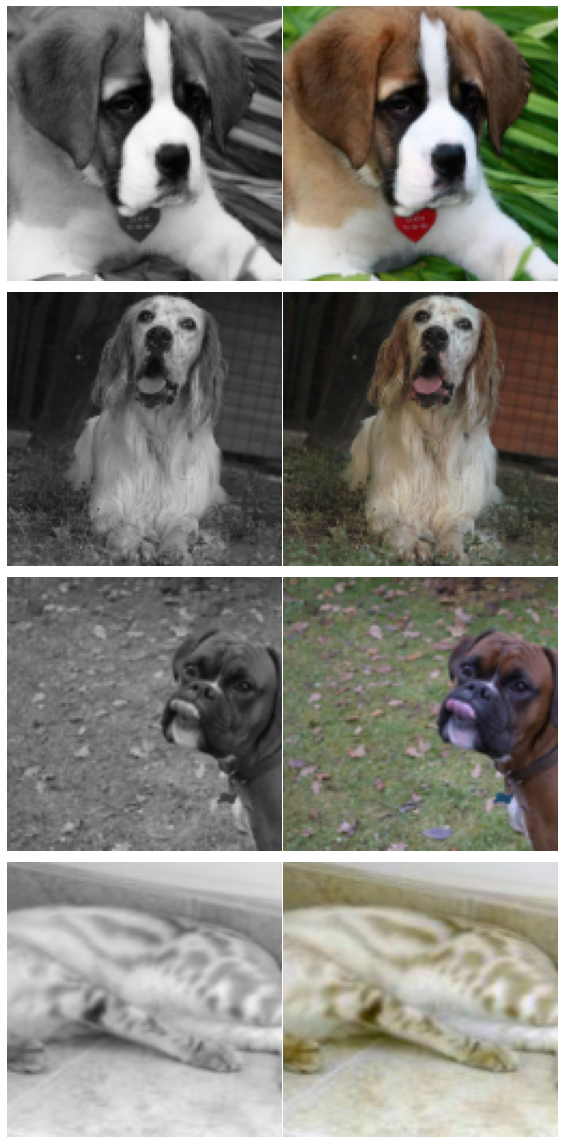

In [12]:
data_gen.show_batch(4)

In [13]:
wd = 1e-3

In [14]:
y_range = (-3.,3.)

In [15]:
loss_gen = MSELossFlat()

In [16]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [17]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [18]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn

KeyboardInterrupt: ignored

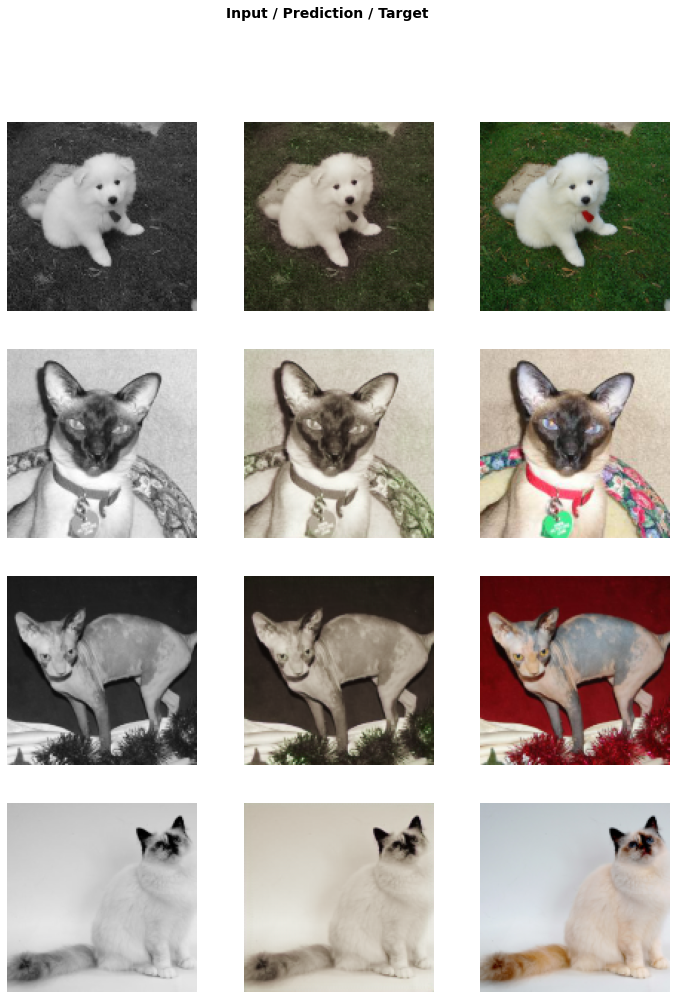

In [25]:
learn_gen.show_results(rows=4)

In [24]:
learn_gen.save('gen-pre2')

## Save generated images

In [26]:
learn_gen.load('gen-pre2');

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [28]:
# shutil.rmtree(path_gen)

In [29]:
path_gen.mkdir(exist_ok=True)

In [30]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [31]:
save_preds(data_gen.fix_dl)

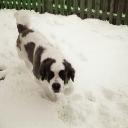

In [32]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [33]:
learn_gen=None
gc.collect()

7

Pretrain the critic on crappy vs not crappy.

In [34]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [35]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

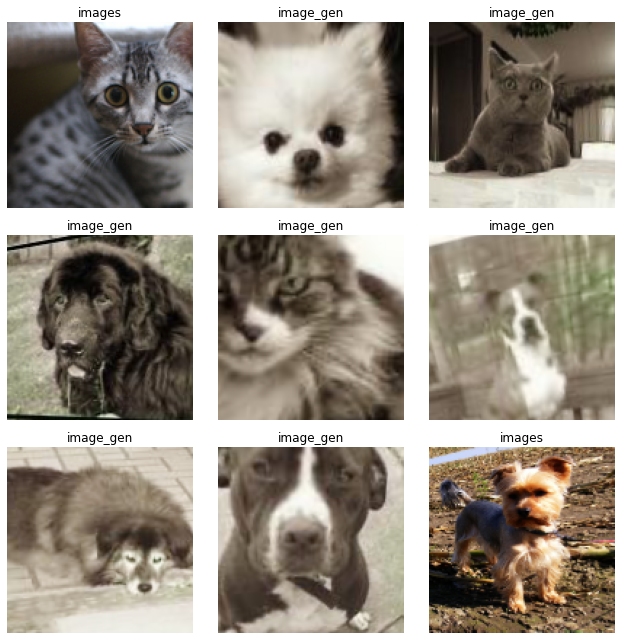

In [36]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [37]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [38]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [39]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [40]:
learn_critic.fit_one_cycle(6, 1e-3)

In [41]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [42]:
learn_crit=None
learn_gen=None
gc.collect()

19450

In [43]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [44]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [45]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [46]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [47]:
lr = 1e-4

In [49]:
learn.fit(5,lr)

In [50]:
learn.save('gan-1c')

In [51]:
learn.data=get_data(16,192)

In [52]:
learn.fit(10,lr/2)

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

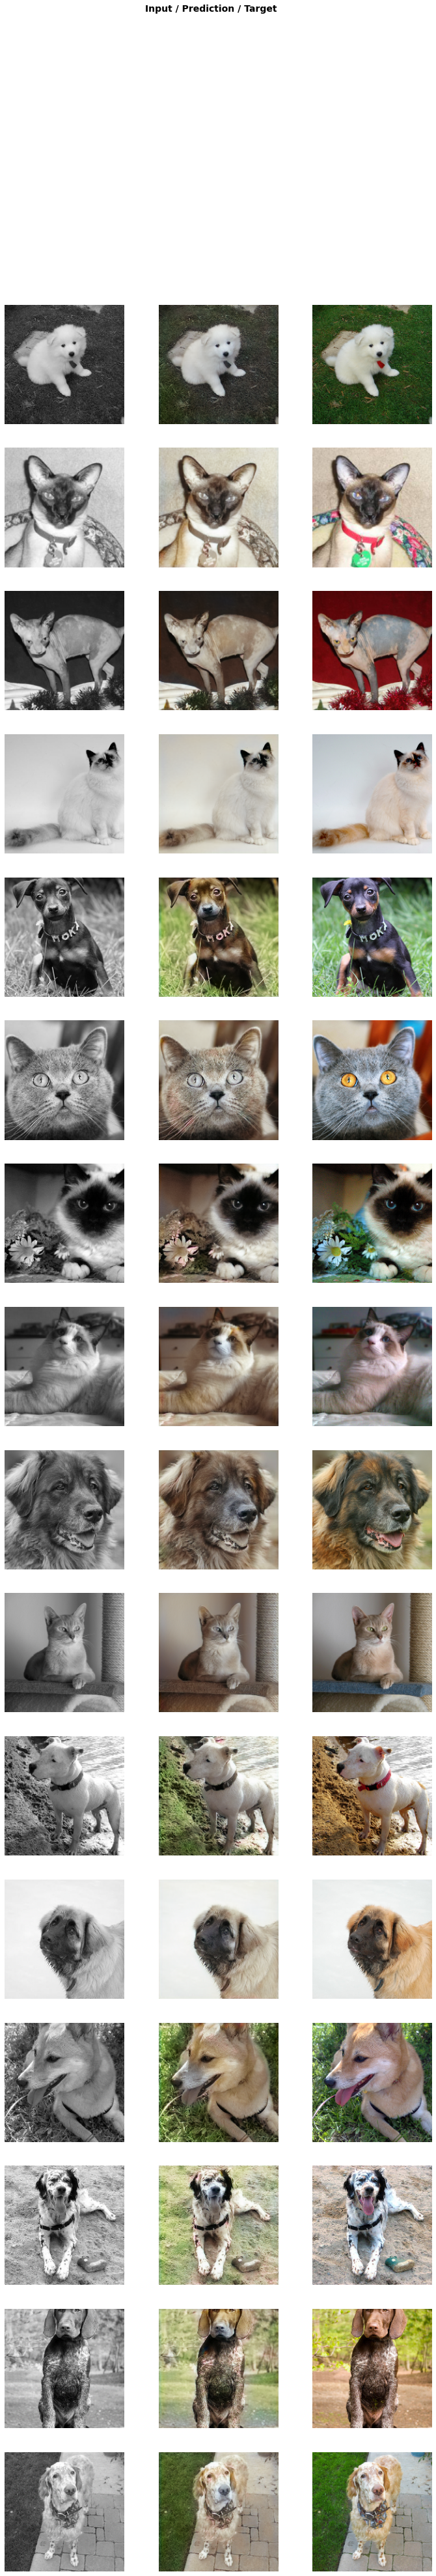

In [53]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin